In [10]:
#Importing all the packages that will be used
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import math
pd.set_option('display.max_rows', 3000)
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import math
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.preprocessing import RobustScaler

In [11]:
import os
os.getcwd()

'/Users/neutonfonseca/Neuton/NYC Data Science Bootcamp/Machine Learning/PROJECT'

In [12]:
os.chdir('/Users/neutonfonseca/Neuton/NYC Data Science Bootcamp/Machine Learning/PROJECT/')

In [13]:
#Loading the data
#You might need to change the address to where your file is
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [14]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index)

In [15]:
#Save the 'Id' column to use in the final predict
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [16]:
#We use the numpy fuction log1p which applies log(1+x) to all elements of the column SalePrice
train["SalePrice"] = np.log1p(train["SalePrice"])

In [17]:
#Joining training and test data so we can perform feature engineering on both
ntrain = train.shape[0]
ntest = test.shape[0] #use this for splitting up all_data later
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

(2917, 79)

In [18]:
#Implementing feature egineering
all_data = all_data.drop(labels = 'PoolQC', axis = 1)
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(0)
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt','GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['GrLivArea2'] = (all_data['GrLivArea']**(1/2))
all_data = all_data.drop('GrLivArea', axis = 1)
all_data['HalfBath2'] = all_data['HalfBath']
all_data.loc[all_data['HalfBath'] >= 1,'HalfBath2'] = .5
all_data['Bathrooms'] = all_data['FullBath'] + all_data['HalfBath2']
all_data = all_data.drop('FullBath', axis = 1)
all_data = all_data.drop('HalfBath', axis = 1)
all_data = all_data.drop('HalfBath2', axis = 1)
all_data['LotArea2'] = np.log(all_data['LotArea']+1)
all_data = all_data.drop('LotArea', axis = 1)
all_data['LotFrontage'] = all_data['LotFrontage'].astype(int)
all_data['LotFrontage2'] = (all_data['LotFrontage']**(1/2))
all_data = all_data.drop('LotFrontage', axis = 1)
all_data['ShedSF'] = 0
all_data.loc[all_data['MiscFeature'] == 'Shed', 'ShedSF'] = all_data['MiscVal']
all_data = all_data.drop('MiscFeature', axis = 1)
all_data = all_data.drop('MiscVal', axis = 1)
all_data = all_data.drop('TotalBsmtSF', axis = 1)
all_data = all_data.drop('LowQualFinSF', axis = 1)
all_data = all_data.drop('3SsnPorch', axis = 1)
all_data = all_data.drop('Alley', axis = 1) #93% of the data is NA
all_data = all_data.drop('BldgType', axis = 1) #Very unbalanced
all_data = all_data.drop('Condition2', axis = 1) #99% of the data has Normal as answer
all_data['HasFence'] = 0
all_data.loc[all_data['Fence'] != 'NA','HasFence'] = 1
all_data = all_data.drop('Fence', axis = 1)
all_data = all_data.drop('GarageQual', axis = 1)
all_data = all_data.drop('GarageYrBlt', axis = 1) #Does the garage built year matter? No. Might try creating ranges
#HouseStyle and MSSubClass MAY CONTAIN THE SAME INFORMATION. WE SHOULD TEST DROPING ONE OF THEM.
all_data = all_data.drop('MSSubClass', axis = 1)
all_data = all_data.drop('MoSold', axis = 1) #There is no very significant difference between months,

In [19]:
#Selecting columns to apply LabelEncoder
from sklearn.preprocessing import LabelEncoder
cols = ('GarageCond','FireplaceQu', 'BsmtQual', 'BsmtCond', 
        'ExterQual', 'ExterCond','HeatingQC',
        'KitchenQual', 'Functional', 'BsmtFinType1', 'BsmtFinType2',
        'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 
        'CentralAir', 'OverallCond', 
        'YrSold')
#Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [20]:
###Use below code for SVR only

#numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# Check the skew of all numerical features
#skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
#print("\nSkew in numerical features: \n")
#skewness = pd.DataFrame({'Skew' :skewed_feats})
#skewness.head(10)

#skewness = skewness[abs(skewness) > 0.75]
#print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
#from scipy.special import boxcox1p
#skewed_features = skewness.index
#lam = 0.15
#for feat in skewed_features:
#    all_data[feat] = boxcox1p(all_data[feat], lam)
#    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [21]:
#Getting dummies for categorical features
all_data = pd.get_dummies(all_data)

In [22]:
#Splitting the data into train and test
train = all_data[:ntrain]
test = all_data[ntrain:]

In [23]:
#Defining a function to calcule the RMSE
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [24]:
#Best score is without removing logs/skewness (alpha = .0005, score = .1090)
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.cross_validation import cross_val_score
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
lasso.fit(train.values, y_train)
print("lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

lasso score: 0.1090 (0.0060)



In [25]:
#Best score is without removing logs/skewness (alpha = .0006, l1_ratio = .8, score = .1091)
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0006, l1_ratio=.8, random_state=3))
score = rmsle_cv(ENet)
ENet.fit(train.values, y_train)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1091 (0.0060)



7     0.111044
8     0.111023
9     0.111023
10    0.111039
dtype: float64

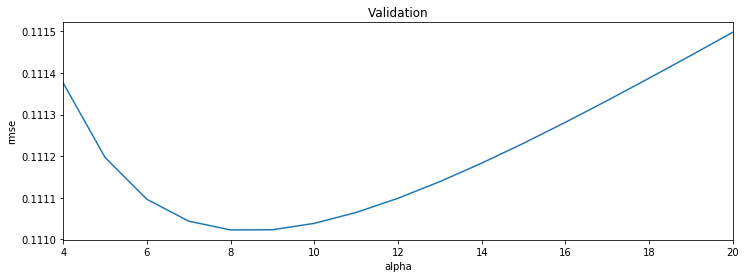

In [27]:
#Testing the best alpha for ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

alphas = [4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
cv_ridge = [rmse_cv(linear_model.Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
#alpha = 6 is the best option
cv_ridge[3:7]

In [28]:
#best score is without removing logs/skewness (alpha = 8, score = .1109)
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model

ridge = make_pipeline(RobustScaler(), linear_model.Ridge(alpha = 8, random_state=1))
score = rmsle_cv(ridge)
ridge.fit(train.values, y_train)
print("ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ridge score: 0.1109 (0.0058)



In [29]:
#Using GridSearchCV to find the best parameters for SVR
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
parameters = {'kernel':['rbf'], 'C':[1,10,50,100], 'gamma':[1e-7, .1],'epsilon':[0.0000001,0.2]}
svc1 = svm.SVR()
clf1 = GridSearchCV(svc1, parameters, verbose = 1)
clf1.fit(train.values, y_train)
clf1.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   18.2s finished


{'C': 10, 'epsilon': 1e-07, 'gamma': 1e-07, 'kernel': 'rbf'}

In [30]:
#Running SVR
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.cross_validation import cross_val_score
SVR = make_pipeline(SVR(kernel = 'rbf', C = 100, gamma = 0.001, epsilon = 0.0001))
score = rmsle_cv(SVR)
SVR.fit(train.values, y_train)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

SVR score: 0.3955 (0.0168)



In [31]:
#Predicting the SalePrice and creating the csv file for submission using Lasso
lasso_pred_train = np.expm1(lasso.predict(train.values))
lasso_pred_test = np.expm1(lasso.predict(test.values))
lasso_pred_test = pd.DataFrame({'Id': test_ID, 'SalePrice': lasso_pred_test})
lasso_pred_test.to_csv('Lasso_submission.csv', index = False)

In [32]:
#Predicting the SalePrice and creating the csv file for submission using Ridge
ridge_pred_train = np.expm1(ridge.predict(train.values))
ridge_pred_test = np.expm1(ridge.predict(test.values))
ridge_pred_test = pd.DataFrame({'Id': test_ID, 'SalePrice': ridge_pred_test})
ridge_pred_test.to_csv('Ridge_submission.csv', index = False)

In [33]:
#Predicting the SalePrice and creating the csv file for submission using ElasticNet
ENet_pred_train = np.expm1(ENet.predict(train.values))
ENet_pred_test = np.expm1(ENet.predict(test.values))
ENet_pred_test = pd.DataFrame({'Id': test_ID, 'SalePrice': ENet_pred_test})
ENet_pred_test.to_csv('ENet_submission.csv', index = False)

In [34]:
#Predicting the SalePrice and creating the csv file for submission using SVR
svr_pred_train = np.expm1(SVR.predict(train.values))
svr_pred_test = np.expm1(SVR.predict(test.values))
SVRSubmission = pd.DataFrame({ 'Id': test_ID, 'SalePrice': svr_pred_test})
SVRSubmission.to_csv("SVRSubmission_test.csv", index=False)